# Etivity Assignment 2: Object co-localisation
In this assignment we will use the [Deep Descriptor Transforming (DDT) Technique](https://arxiv.org/pdf/1707.06397.pdf) to perform object co-localisation. The object localisation task involves finding the location of the primary object in an image (same object as image classification result). In the object co-localisation task the goal is to find the objects in images all of the same class. As detailed in the DDT paper, this can be achieved in a unsuperivsed manner from the feature map outputs of a pre-trained network. (In the image: Green bounding box is ground truth, Red boxes are obtained from DDT)
![link text](https://github.com/tonyscan6003/etivities/blob/main/etivity3_assignment_img.JPG?raw=true)

This technique (like Class activiation mapping) demonstrates that spatial information is contained with Deep Neural Networks trained for classification. This information can be used to generate region proposals or for direct object detection. The  unsupervised technique proposed in this paper is useful as it avoids the necessity of having bounding box information to adapt the pre-trained network for localisation.

In this Assignment you will perform object co-localisation using the stanford dogs dataset and the pre-trained VGG-16 network. This Jupyter notebook loads the stanford dogs dataset and also sets up the pre-trained Keras VGG-16 model so that the features of the convolutional layer are output. (Output layers of the model can be changed if required).  

In section 4. of the notebook you will implement the DDT algorithm and demonstrate prediction of bounding boxes. (Ground truth bounding boxes are available for comparison with your prediction).

You may find the following information useful:

*   [Sklearn PCA Functions](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
* [Tensorflow resize](https://www.tensorflow.org/api_docs/python/tf/image/resize) (interpolation function)
*   OpenCV Connected Components (PyImageSearch example [link text](https://www.pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/)) Note that if you want to use OpenCv on the output tensors then it will be necessary to need to convert the tensor to a numpy array uisng `.numpy()` and also ensure that have the numpy array in uint8 format `.astype(np.uint8)`
* If you wish to display any of the images from the dataset, please note that they have been processed prior to input to the network. In order to unprocess the image for display, please use: `helper.unprocess_image(img)`

In order to obtain an exemplary grade you will be required to implement the DDT+ algorithm. This will involve use of additional feature map information to refine the position of the bounding box compared to the basic approach (as shown in the images below). You will implement the DDT+ algorithm on the [Pascale Visual Object Classes Challenge](https://homepages.inf.ed.ac.uk/ckiw/postscript/ijcv_voc09.pdf) "Sheep" class. This is more challenging than the stanford dogs dataset, as objects appear at different scales. Note that the DDT+ approach also causes failures in bounding boxes for many images, you can comment on this in your notebook. 

Image: DDT+ Performance (Cyan: DDT+ bouding boxes, Red DDT: bounding boxes, Green: Ground Truth) 

![link text](https://github.com/tonyscan6003/etivities/blob/main/etivity3b_assignment.JPG?raw=true)

* Note: Completed list of VoC Classes 0-airplane, 1-bicycle, 2-bird, 3-boat, 4-bottle, 5-bus, 6-car, 7-cat, 8-chair, 9-cow, 10-dining table, 11-dog, 12-horse, 13-motorbike, 14-person, 15-potted plant, 16-sheep, 17-sofa, 18-train, 19-TV/monitor.










# 1. HouseKeeping
 Clone Repository & Import Packages 

In [115]:
# Clone repository to gain access to helper.py
!git clone https://github.com/tonyscan6003/etivities.git

fatal: destination path 'etivities' already exists and is not an empty directory.


In [116]:
import tensorflow as tf
import etivities.helper as helper
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow_datasets as tfds

In [117]:
# Global Variables
HW_trg = helper.myList[0]      # Target Input Image size
batch_size = helper.myList[1]  # Batch Size
# data_set = ["stanford_dogs"]   # Dataset (and add class integer to list for VoC))
data_set = ["voc",16]    # VoC Dataset with Sheep Class

## 2A. Import Dataset

In [118]:

if data_set[0] == "voc":   
   src_train_dataset,info = tfds.load(data_set[0],split='train',with_info=True)
   src_val_dataset,info = tfds.load(data_set[0],split='validation',with_info=True)
   src_test_dataset,info = tfds.load(data_set[0],split='test',with_info=True)
elif data_set[0] == "stanford_dogs":
   src_train_dataset,info = tfds.load(data_set[0],split='train',with_info=True)
   src_test_dataset,info = tfds.load(data_set[0],split='test',with_info=True)
print(info)

tfds.core.DatasetInfo(
    name='voc',
    full_name='voc/2007/4.0.0',
    description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge,
    corresponding to the Classification and Detection competitions.
    
    In the Classification competition, the goal is to predict the set of labels
    contained in the image, while in the Detection competition the goal is to
    predict the bounding box and label of each individual object.
    annotations.
    """,
    config_description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge
    2007, a.k.a. VOC2007.
    
    A total of 9963 images are included in this dataset, where each image
    contains a set of objects, out of 20 different classes, making a total of
    24640 annotated objects.
    
    """,
    homepage='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/',
    data_path='~/tensorflow_datasets/voc/2007/4.0.0',
    file_format=tfrecord,
    download_size=868.

## 2B. Create Train and Test dataset splits 

Note that the images from the stanford dog and many other datasets are not uniform in size. The `gen_datasets` function calls other routines from helper.py that scale the images from the dataset so the longest side fits into the 224 x 224 input window size of VGG16. The aspect ratio of the image is preserved, so the shorter side of the image is padded with zeros. The shorter side is randomly translated providing some data augmentation. (Augmentation is not important for this task). The routines also scale ground truth bounding boxes to match the scale and translation of the image.

In [119]:
train_dataset, test_dataset =helper.gen_datasets(data_set,src_train_dataset,src_test_dataset)

Display Some Training Images with Ground truth Bounding Box

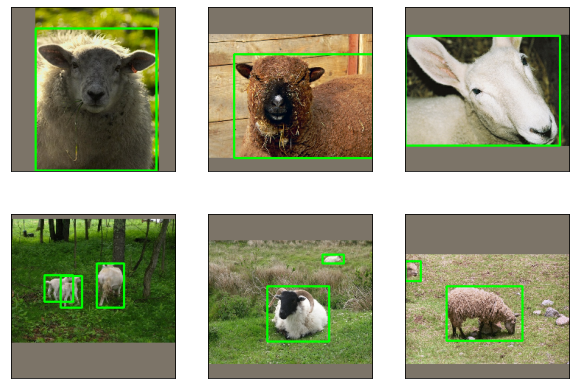

In [120]:

helper.display_dataset_img(train_dataset)


## 3A. Import and Setup VGG model
For this assignment we will use the convolutional layers of the VGG-16 module. The sturucture & layer names of the VGG-16 can be viewed on [Netscope](https://ethereon.github.io/netscope/#/preset/vgg-16). The layer_names variable allows selection of the output layer(s) of the model.


In [121]:
# Select Output Layers
layer_names = ['block4_conv3','block5_conv3']

# Load base model
def base_vgg_model():
   IMG_SHAPE = (HW_trg, HW_trg, 3)
   base_vgg_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             weights='imagenet')
   
   op_list=[base_vgg_model.get_layer(layer).output for layer in layer_names]
   base_model= tf.keras.Model(inputs=base_vgg_model.input, outputs=op_list)

   return base_model


In [122]:
base_model = base_vgg_model()
base_model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## 3B. Extract output features maps from Model.

The function `gen_batch_features` in the code cell below applies `n_img` images from the test or training set to the model. The function returns batch tensors of the image, ground truth boxes and features. The 0 dimension of the tensor corresponds to each image/feature pair.

In [123]:
def gen_batch_features(train_dataset,n_img):

    cntr = 0
    for img, boxes, obj_cen, labels in train_dataset.take(n_img):
       img = img.to_tensor(shape=[batch_size, HW_trg, HW_trg, 3])
       A = base_model(img)[0]
       B = base_model(img)[1]

       # Append output features 
       if cntr >0:
          op_features_1 = tf.concat([op_features_1,A],axis=0)
          op_features_2 = tf.concat([op_features_2,B],axis=0)
          img_batch = tf.concat([img_batch,img],axis=0)
          boxes_batch = tf.concat([boxes_batch,boxes],axis=0)
       else:   
          op_features_1 = A
          op_features_2 = B
          img_batch = img
          boxes_batch = boxes
       cntr +=1  
     
    return img_batch,boxes_batch,op_features_1,op_features_2 

In [124]:
n_img=100 # Default value.
img_batch,batch_boxes,op_features_1,op_features_2=gen_batch_features(train_dataset,n_img)
img_batch_test,batch_boxes_test,op_features_1_test,op_features_2_test=gen_batch_features(test_dataset,n_img)


In [125]:
print(np.shape(op_features_1), np.shape(op_features_2))
print(np.shape(batch_boxes_test))
print(np.shape(img_batch_test))
print(np.shape(op_features_1_test))

(45, 28, 28, 512) (45, 14, 14, 512)
(93, None, 4)
(93, 224, 224, 3)
(93, 28, 28, 512)


## 4. DDT Algorithm

In the code cells below add your implementation of the DDT Algorithm for object co-localisation.


In [126]:
from sklearn.decomposition import PCA
import cv2

In [127]:
# 3: Calculate the mean vector x¯ of all the descriptors using Eq. 1;
# 4: Compute the covariance matrix Cov(x) of these deep descriptors based on Eq. 2;
# 5: Compute the eigenvectors ξ1, . . . , ξd of Cov(x);
# 6: Select ξ1 with the largest eigenvalue as the main transforming direction;

num_imgs, w, h, c = np.shape(op_features_2)

op_features_reshape = np.reshape(op_features_2, [num_imgs*w*h, c])
print(np.shape(op_features_reshape))

pca = PCA(n_components=1)
pca.fit(op_features_reshape)

(8820, 512)


PCA(n_components=1)

In [128]:
#7: repeat
#8: Calculate the indicator matrix P1 for image I based on Eq. 3 and Eq. 4;
#9: Resize P1 into its image’s resolution by nearest interpolation;

test_num_imgs, test_w, test_h, test_c = np.shape(op_features_2_test)
op_features_test_reshape = np.reshape(op_features_2_test, [test_num_imgs*test_w*test_h, test_c])
op_features_test_reshape.shape
op_features_test_transform = pca.transform(op_features_test_reshape)
op_features_test_transform.shape

(18228, 1)

In [129]:
# image original size
o_num_imgs, o_w, o_h, o_c = np.shape(img_batch_test)

In [130]:
indicator_map = np.reshape(op_features_test_transform, (test_num_imgs, test_w, test_h))
indicator_map_224 = np.zeros((len(indicator_map), o_w, o_h))
for idx in range(len(indicator_map)):
  img = indicator_map[idx, :, :]
  img_sm = cv2.resize(img, (o_w, o_h), interpolation=cv2.INTER_NEAREST)
  indicator_map_224[idx, :, :] = img_sm

binary_map = np.uint8(cv2.threshold(np.asarray(indicator_map),0,255,cv2.THRESH_BINARY)[1])
binary_map_224 = np.uint8(cv2.threshold(np.asarray(indicator_map_224),0,255,cv2.THRESH_BINARY)[1])

In [131]:
#10: Collect the largest connected component Pˆ1c of these positive regions of the resized P1 by Algo. 1;
#11: Obtain the minimum rectangle bounding box covering Pˆ1c as the prediction;
def connected_component(binary_map):
  output = cv2.connectedComponentsWithStats(binary_map, 4, cv2.CV_32S)
  (numLabels, labels, stats, centroids) = output

  # loop over the number of unique connected component labels
  for i in range(0, numLabels):
    # extract the connected component statistics and centroid for
    # the current label
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
  return [x, y, x+w, y+h]

In [132]:
def image_with_pred_boxes(img, box, colour):      
    # draw a green rectangle to visualize the bounding rect
    return cv2.rectangle((img), (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), colour, 2)

In [133]:
pred_bbox = []
for b_map in binary_map_224:
  pred_bbox.append(connected_component(b_map))

## 4.1. DDT+ Algorithm


In [134]:
num_imgs_plus, w_plus, h_plus, c_plus = np.shape(op_features_1)

op_features_reshape_plus = np.reshape(op_features_1, [num_imgs_plus*w_plus*h_plus, c_plus])
print(np.shape(op_features_reshape_plus))

pca_plus = PCA(n_components=1)
pca_plus.fit(op_features_reshape_plus)

(35280, 512)


PCA(n_components=1)

In [135]:
test_num_imgs_plus, test_w_plus, test_h_plus, test_c_plus = np.shape(op_features_1_test)
op_features_test_reshape_plus = np.reshape(op_features_1_test, [test_num_imgs_plus*test_w_plus*test_h_plus, test_c_plus])
op_features_test_reshape_plus.shape
op_features_test_transform_plus = pca_plus.transform(op_features_test_reshape_plus)
op_features_test_transform_plus.shape

(72912, 1)

In [136]:
indicator_map_plus = np.reshape(op_features_test_transform_plus, (test_num_imgs_plus, test_w_plus, test_h_plus))
indicator_map_224_plus = np.zeros((len(indicator_map_plus), o_w, o_h))
for idx in range(len(indicator_map_plus)):
  img = indicator_map_plus[idx, :, :]
  img_sm = cv2.resize(img, (o_w, o_h), interpolation=cv2.INTER_NEAREST)
  indicator_map_224_plus[idx, :, :] = img_sm

binary_map_224_plus = np.uint8(cv2.threshold(np.asarray(indicator_map_224_plus),0,255,cv2.THRESH_BINARY)[1])
# combine
binary_map_224_plus = binary_map_224_plus + binary_map_224

In [137]:
mask = binary_map_224[0] + binary_map_224_plus[0]
mask[mask==255] = 0
mask[mask==510] = 255

In [138]:
pred_bbox_plus = []
for b_map in binary_map_224_plus:
  b_map[b_map==255] = 0
  b_map[b_map==510] = 255
  pred_bbox_plus.append(connected_component(b_map))

# 5. Display results

You can display your results using the code cell below. You can display an image(s) similar to that shown at the start of the notebook, containing the image, ground truth bounding box and the bounding box produced by the DDT method. You can also show the binary map produced by indicator P (positive values).

The function `helper.image_with_gt_boxes(img,boxes,colour)` can be used to plot a bounding box on an image where the bounding box is in the form [ymin,xmin,ymax,xmax] and values are normalised between zero and 1. 

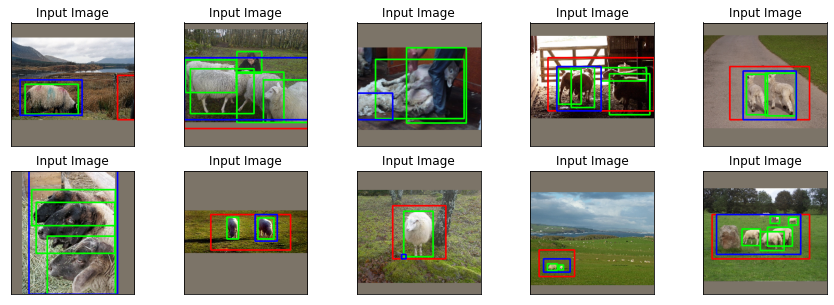

In [139]:
fig = plt.figure(figsize=(15, 5))
n=10

# Iterate through some images
for k in range(n):
   curr_img = np.asarray(helper.unprocess_image(img_batch_test[k, :, :,:]))
   # draw a green rectangle to visualize the bounding rect
   curr_img=helper.image_with_gt_boxes(curr_img,batch_boxes_test[k],(0,255,0))
   
   curr_img = image_with_pred_boxes(curr_img, pred_bbox[k], (255, 0, 0))

   curr_img = image_with_pred_boxes(curr_img, pred_bbox_plus[k], (0, 0, 255))
   # Plot image and show related indicator
   ax = fig.add_subplot(n/5, 5, k + 1, xticks=[], yticks=[])
   ax.imshow(curr_img)
   ax.set_title('Input Image')  



- **Green** => GT
- **Red** => DDT
- **Blue** => DDT+